# Transient Flow, Single Layer Aquifer

This example is adapted from the Obleo aquifer case, with modifications to make into an unsteady model.

## Obleo Aquifer Unsteady Example 
This is a transient model of the Obleo aquifer system 

:::{note}
This model is the identical conceptualization as the prior model, except we will use unsteady flow modeling.  We run the simulation to near equilibrium and should get about the same results.
:::

![](obleoaquifer.png)

Sone added information about the system is:

![](obleoparticulars.png)

The general goals for the analysis are:

![](obleogoals.png)

So with a little infomration regarding how we will manage elevations we can move forward with the modeling effort.

![](obleovertdatum.png)

Now onto **modflow**

:::{warning}
Nearly every cell throws a deprecation warning, that filterwarnings('ignore') fails to suppress.  Code seems to still run on my server, but over time as new updates are added to the kernel the code at some point will fail without addressing the warning.  The development computer is `aarch64` an arm processor.  The AWS server is `amd64/intel` architecture, which gets a lot of code development so should stay current longer.  This continuous integration CI and push changes model of modern IT support is phenomenally annoying, but for time being have to get used to it.
:::

In [16]:
%reset -f

In [17]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [18]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

In [19]:
#dir(flopy.mf6)

In [20]:
# Workspace and Executibles
#binary = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6"  # location on MY DEVELOPMENT computer of the compiled modflow program
#workarea = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/example_3" # location on MY DEVELOPMENT computer to store files this example (directory must already exist)

binary = "/home/sensei/mfplayground/modflow-python/mf6.4.1_linux/bin/mf6"  # location on AWS computer of the compiled modflow program
workarea = "/home/sensei/ce-5364-webroot/mfexperiments/example_2" # location on MY computer to store files this example (directory must already exist)

# Set Simulation Name
name = "example_2"
#modelname=name

##### FLOPY Build simulation framework ####
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name=binary, version="mf6", sim_ws=workarea
)

In [21]:
# Set Time Structure
Time_Units="YEARS"

# Multiple stress periods
nper = 3 # how many periods
perlen = [1.0, 100.0, 100.0] # how long each one
nstp = [1, 100, 100] # how many steps in each
steady = [True, False, False] # which ones are steady

perioddata = [(1.0,1,1),(30.0,30,1),(30.0,30,1)]

##### FLOPY Build time framework ##########
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units=Time_Units, nper=3, perioddata=perioddata,
)

In [22]:
# Set Iterative Model Solution (choose solver parameters)
# about IMS see: https://water.usgs.gov/nrp/gwsoftware/ModelMuse/Help/sms_sparse_matrix_solution_pac.htm
# using defaults see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfims.html

##### FLOPY Build IMS framework ###########
ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE")

In [23]:
# Set Model Name (using same base name as the simulation)
model_nam_file = "{}.nam".format(name)

##### FLOPY Build Model Name framework ####
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

In [24]:

# Define The Grid
Nlay = 1 #number layers
Nrow = 11 #number rows
Ncol = 11 #number columns
# Define distances and elevations
delrow = 1000 # cell size along columns (how tall is a row)
delcol = 1000 # cell size along row (how wide is a column)
topelev = 100.0 # elevation of top of aquifer
thick = 1000.0 #aquifer thickness

bot = [topelev-thick] # bot is a list with Nlay entries
#print(bot)


##### FLOPY Build Model Grid framework #####
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=Nlay,nrow=Nrow,ncol=Ncol,delr=delrow,delc=delcol,top=topelev,botm=bot,
)


In [25]:
# Define initial conditions
h1 = 0.0 # 
start = h1 * np.ones((Nlay, Nrow, Ncol)) # start heads are h1 everywhere

##### FLOPY Build Initial Conditions framework ###
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

In [26]:
# Define hydraulic conductivity arrays
K = 3650.0
k = K * np.ones((Nlay, Nrow, Ncol)) # Hydraulic conductivity is K everywhere
# Use above to build layer-by-layer spatial varying K
# need to read: to deal with Kx!=Ky

##### FLOPY Build BCF framework ######
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k, save_flows=True) 
# setting icelltype > 0 is unconfined 
# https://flopy.readthedocs.io/en/3.3.5/source/flopy.mf6.modflow.mfgwfnpf.html?highlight=icelltype#flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf.icelltype

In [27]:
# Define the storativity arrays
Sy = 0.25 # specific yield
Ss = 2.5e-4 # specific storage

sto = flopy.mf6.ModflowGwfsto(gwf, sy=Sy)

In [28]:
# Define constant head boundary conditions - these need to be supplied for each stress period
chd_rec = []
#h2 = 90 # Just a different value 
#chd_rec.append(((0, 5, 5), h2))
# L,R,T,B constant head boundaries
for layer in range(0, Nlay):
    for row in range(0, Nrow):
        chd_rec.append(((layer, row, 0), h1))  #left column held at h1
        chd_rec.append(((layer, row, Ncol-1), h1)) #right column held at h1
#    for col in range(1,Ncol-1):
#        chd_rec.append(((layer, 0, col), h1)) # top row held at h1
#        chd_rec.append(((layer, Nrow-1 , col), h1)) # bottom row held at h1

stress_period_data = {0: chd_rec, 1: chd_rec, 2: chd_rec} # dictionary same BC each stress period
        
##### FLOPY Build CHD framework #####          
chd = flopy.mf6.ModflowGwfchd(gwf,maxbound=len(chd_rec),stress_period_data=stress_period_data,save_flows=True,
)

In [29]:
# Define wellfields
#wel_rec = []
# wel_rec.append((0, 5, 5, -0e6)) # 0 Mm3/yr - use to examine recharge only
#wel_rec.append((0, 5, 5, -2114e6)) # 2,114 Mm3/yr
# Multiple Stress Periods
pumping_rate = -1000e6
wel_sp1 = [[0, 5, 5, 0.0]]
wel_sp2 = [[0, 5, 5, 1*pumping_rate]]
wel_sp3 = [[0, 5, 5, 2.115*pumping_rate]]
stress_period_data = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}
#wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)



##### FLOPY Build Wellfields framework #####  
wel = flopy.mf6.ModflowGwfwel(gwf,maxbound=1,stress_period_data=stress_period_data,)

In [30]:
# Define recharge
rech_val = 0.25 #  rate as depth/year
rech_rec = rech_val * np.ones((1, Nrow, Ncol)) # set recharge top layer only

rec_sp1 = rech_rec
rec_sp2 = rech_rec
rec_sp3 = rech_rec

stress_period_data = {0: rec_sp1, 1: rec_sp2, 2: rec_sp3}

#rch = flopy.mf6.ModflowGwfrcha(gwf, maxbound=len(rech_rec),recharge=stress_period_data,)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=stress_period_data,)

#rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rech_val) # default entry format

In [31]:
# something to do with stress periods
iper = 0
ra = chd.stress_period_data.get_data(key=iper)


In [32]:
# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]

##### FLOPY Build OC framework
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [33]:
# Write files to the directory
sim.write_simulation();

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model example_2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package chd_0...
    writing package wel_0...
    writing package rcha_0...
    writing package oc...


In [34]:
# Attempt to run MODFLOW this model
success, buff = sim.run_simulation(silent=True, report=True)
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

0.9213486227356531


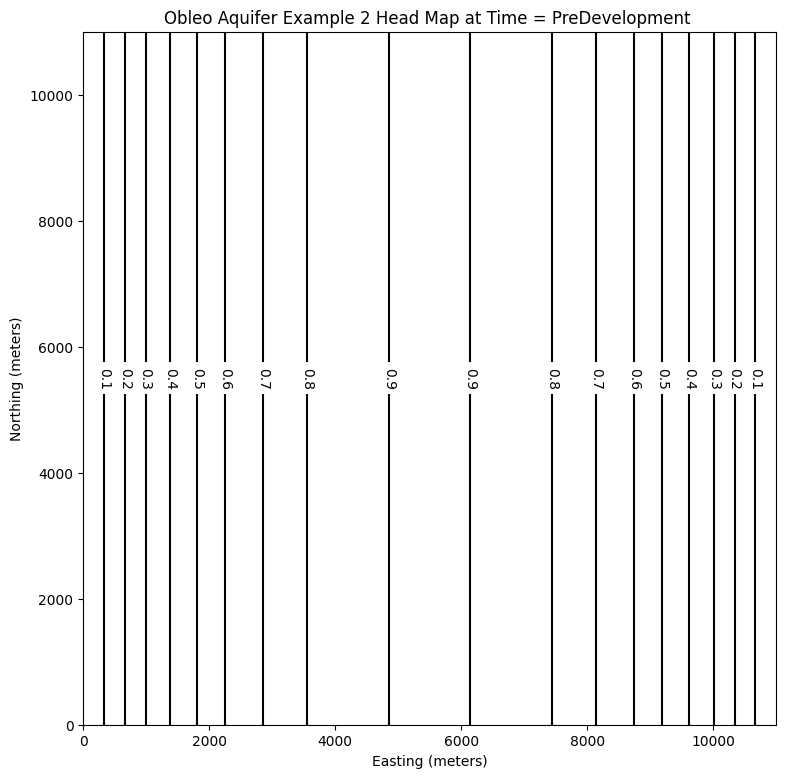

In [35]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(0, 0))
print(h[0].max())
x =  np.linspace(0, delrow*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -200., 100.0
contour_intervals = np.arange(-10., 1.0, 0.1)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Obleo Aquifer Example 2 Head Map at Time = PreDevelopment ")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

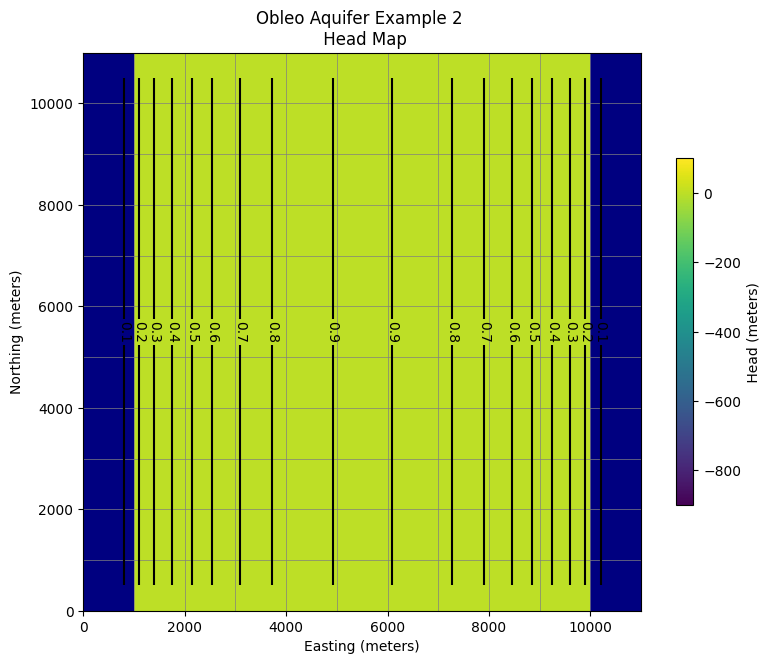

In [36]:
# ### Use the FloPy `PlotMapView()` capabilities for MODFLOW 6

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.set_title("Obleo Aquifer Example 2 \n Head Map")
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)
pa = modelmap.plot_array(h, vmin=-900, vmax=100)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")

cb = plt.colorbar(pa, shrink=0.5, ax=ax)
cb.set_label(' Head (meters) ', rotation=90)

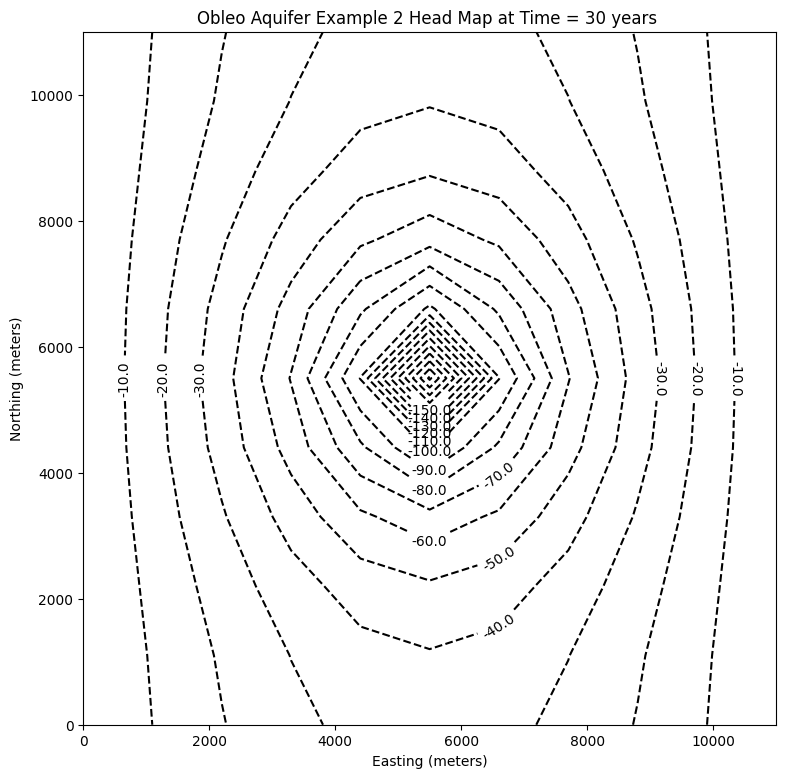

In [37]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(0, 1))
#print(h[0].min())
x =  np.linspace(0, delrow*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -200., 100.0
contour_intervals = np.arange(-200., 1.0, 10)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Obleo Aquifer Example 2 Head Map at Time = 30 years ")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

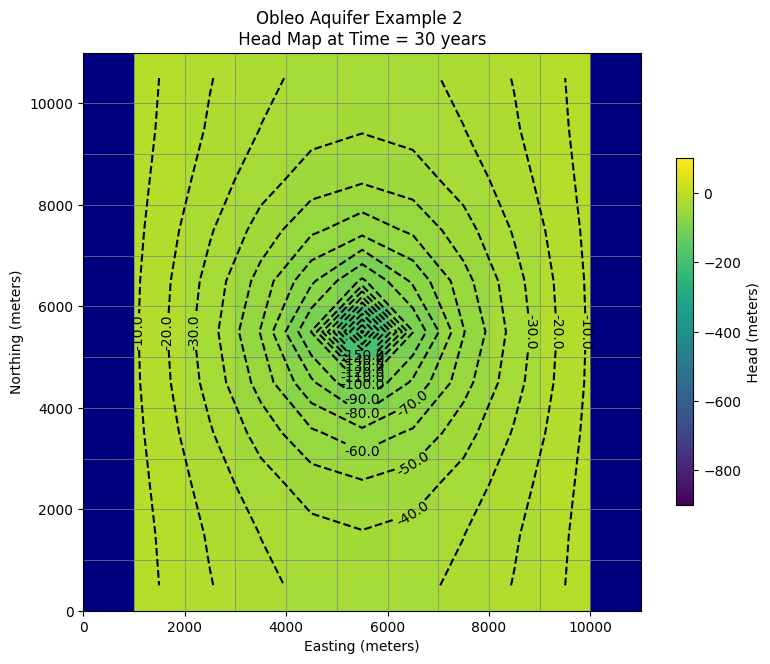

In [38]:
# ### Use the FloPy `PlotMapView()` capabilities for MODFLOW 6

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.set_title("Obleo Aquifer Example 2 \n Head Map at Time = 30 years ")
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)
pa = modelmap.plot_array(h, vmin=-900, vmax=100)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")

cb = plt.colorbar(pa, shrink=0.5, ax=ax)
cb.set_label(' Head (meters) ', rotation=90)

0.0


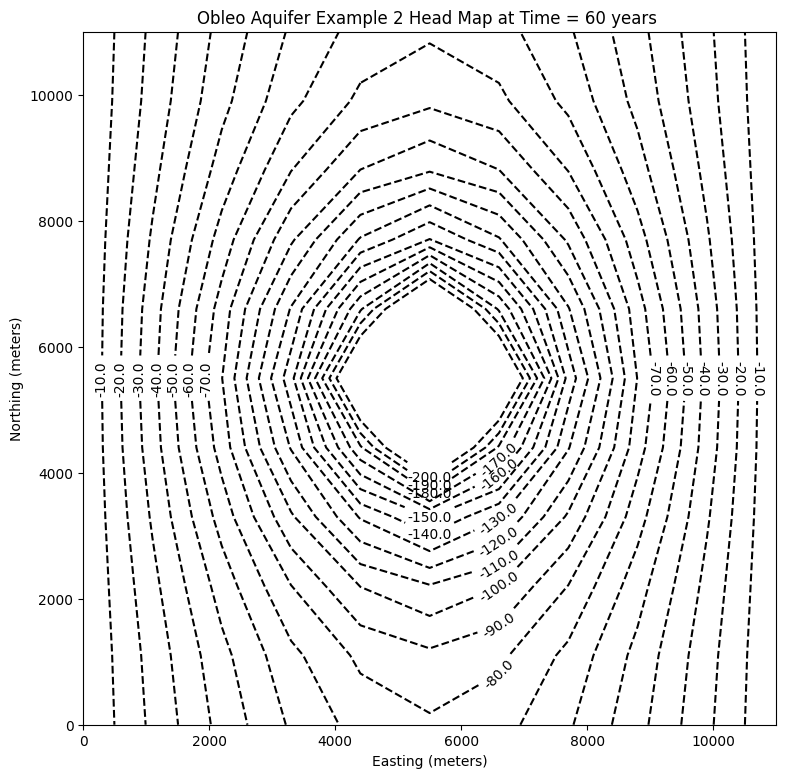

In [39]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(0, 2))
print(h[0].max())
x =  np.linspace(0, delrow*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -200., 100.0
contour_intervals = np.arange(-200., 1.0, 10)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Obleo Aquifer Example 2 Head Map at Time = 60 years ")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

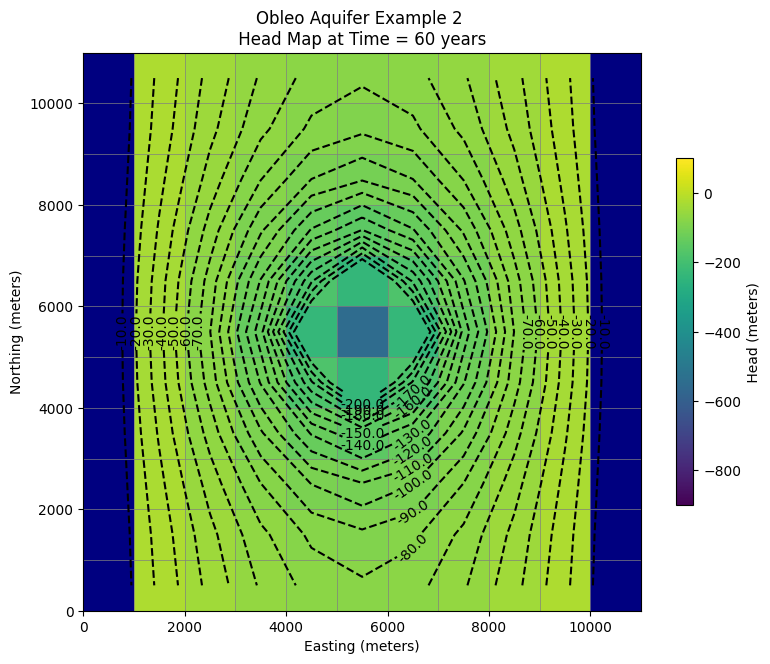

In [40]:
# ### Use the FloPy `PlotMapView()` capabilities for MODFLOW 6

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.set_title("Obleo Aquifer Example 2 \n Head Map at Time = 60 years ")
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)
pa = modelmap.plot_array(h, vmin=-900, vmax=100)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")

cb = plt.colorbar(pa, shrink=0.5, ax=ax)
cb.set_label(' Head (meters) ', rotation=90)

Now for pretty mapping!

So this is the working model, so now we can assess effect of pumping and decide if we can increase the pumping any We already have this information contained in the output object.

In [41]:
print("Minimum allowed is -650.0 meters")
#print("Pumping at P-1 is:",wel_rec[0][3]/1e6," Mm^3/yr")
print("Minimum Head is:",round(h[0].min(),1)," meters")
if h[0].min() < -650.0:
    print("Computed head is below allowed value - reduce pumpage and rerun simulation")

Minimum allowed is -650.0 meters
Minimum Head is: -552.3  meters


## End of Section